# Modules

In [1]:
import numpy as np
import math
import scipy
import py3nj
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_9j
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def neg_1_pow(x):
    return 1 - 2 * (x % 2)


def delta(x1, x2):
    if x1 == x2:
        return True
    else:
        return False
    
def inverse_cm_to_MHz(E_in_inverse_cm):
    return 29979.2458 * E_in_inverse_cm

def val_ct_add_ang_mom(L1, L2, doubled):
    # returns the number of values in the array add_ang_mom
    if doubled:
        incr = 2
    else:
        incr = 1
    
    Lt_max = L1 + L2
    Lt_min = abs(L1-L2)
    
    return int((Lt_max - Lt_min + incr) / incr)

def add_ang_mom(L1, L2, doubled):
    # given the values of two different angular momenta, returns an array 
    # of the possible values of their sum L1+L2 = Lt
    #
    # doubled specifies whether the values of L1 and L2 are doubled upon input
    
    if doubled:
        incr = 2
    else:
        incr = 1
    
    Lt_max = L1 + L2
    Lt_min = abs(L1-L2)
    
    if Lt_max == Lt_min:
        return np.array([Lt_max])
    else:
        Lt = np.zeros(int((Lt_max - Lt_min + incr)/ incr))
        temp = Lt_min
        i = 0
        while temp <= Lt_max:
            Lt[i] = temp
            temp = temp + incr
            i += 1
        return Lt

In [3]:
class Interaction:
    def __init__(self, const, functn):
        # const is some constant associated with the interaction energy
        # funct is a function which evaluates the matrix element <state1|interaction|state2>
        self.const = const
        self.functn = functn
        
    def eval_interaction(self, state1, state2):
        return self.const * self.functn(state1, state2)
        
class State:
    def __init__(self, N, S, J, I, F, mF, doubled):
        # N is 2 times the rotational quantum number
        # S is 2 times the electron spin of the system
        # I is 2 times the total nuclear spin
        # F is 2 times the sum of I and J
        # mF is 2 times the projection of F onto the z axis
        # State class converts these inputs into physical values (halves each)
        
        if doubled:
            self.N = 0.5*N
            self.S = 0.5*S
            self.J = 0.5*J
            self.I = 0.5*I
            self.F = 0.5*F
            self.mF = 0.5*mF
        else:
            self.N = N
            self.S = S
            self.J = J
            self.I = I
            self.F = F
            self.mF = mF
        
    def __str__(self):
        # prints the physical values for each element within the state
        return "N:"+ str(self.N) + " S:" + str(self.S) + " J:" + str(self.J) + " I:" + str(self.I) + " F:" + str(self.F) + " mF:" + str(self.mF)
    
    def get_state_vector(self):
        return [self.N, self.S, self.J, self.I, self.F, self.mF]

In [4]:
add_ang_mom(1, 1, False)

array([0., 1., 2.])

In [5]:
class Molecule:
    
    def __init__(self, N, S, I1, I2, I_range = None, n_Ch_Itrcns = 1):
        # N is an array holding the rotational quantum number
        # S is the electron spin of the system
        # I1 is the nuclear spin of atom one
        # I2 is the nuclear spin of atom two
        #
        # We double each input so that we can work with integer values
        self.N = np.multiply(N, 2)
        self.S = int(2*S)
        self.I1 = int(2*I1)
        self.I2 = int(2*I2)  
        self.states = []
        self.n_Ch_Itrcns = n_Ch_Itrcns
        
        if I_range:
            for n in self.N:
                for j in add_ang_mom(n, self.S, True):
                    for i in np.array(I_range) * 2:
                        for f in add_ang_mom(i, j, True):
                            for mf in np.arange(-f,f+1,2):
                                self.states.append(State(n, self.S, j, i, f, mf, True))
        else:
            for n in self.N:
                for j in add_ang_mom(n, self.S, True):
                    for i in add_ang_mom(self.I1, self.I2, True):
                        for f in add_ang_mom(i, j, True):
                            for mf in np.arange(-f,f+1,2):
                                self.states.append(State(n, self.S, j, i, f, mf, True))

        #for state in self.states:
        #    print(state)
        
        self.dim = len(self.states)
        print("H has dim", self.dim)
        
        # array of interaction functions
        self.interactions = []
        self.changing_interactions = []
        
        #Initialize static Hamiltonian, changing Hamiltonian, and total hamiltonian
        self.H_zero = np.zeros((self.dim,self.dim))
        self.H_primes = np.zeros((n_Ch_Itrcns,self.dim,self.dim))
        
    def add_interaction(self, interaction):
        self.interactions.append(interaction)
        
    def add_changing_interaction(self, interaction):
        # change to add changing interaction
        if(len(self.changing_interactions) > self.n_Ch_Itrcns):
            print("Max changing interactions exceeded for the given molecule object. \n \
                Make a new molecule object with the correct n_Ch_Itrcns parameter.")
        else:
            self.changing_interactions.append(interaction)
    
    def find_H_zero(self):
        if len(self.interactions) == 0:
            print("There are no interactions in the interaction array.")

        # Fill Hamiltonian matrix with term by term 
        for i in range(self.dim):
            for j in range(i,self.dim):
                term_zero = 0
                for interaction in self.interactions:
                    term_zero += interaction.eval_interaction(self.states[i], self.states[j])
                self.H_zero[i][j] = term_zero
                self.H_zero[j][i] = np.conjugate(term_zero)

        return self.H_zero
    
    def find_H_prime(self):
        for index, interaction in enumerate(self.changing_interactions):
            for i in range(self.dim):
                    for j in range(i,self.dim):
                        term_prime = interaction.eval_interaction(self.states[i], self.states[j])
                        self.H_primes[index][i][j] = term_prime
                        self.H_primes[index][j][i] = np.conjugate(term_prime)
                    
        return self.H_primes

    def compute_eigenval_over_range(self, ChItrcnMagnitudes):
        # ChItrcnMagnitudes is a 2d array with 
        # #rows = len(self.changing_interactions) 
        # #cols = len(interaction range to consider)
        #
        # We invert reshape it (just transpose) before running the code below so that:
        # 
        # Each row represents a "frame" of the changing interactions to consider;
        # a given case where each changing interaction equals something
        #
        # Each column represents one of the changing interactions
        #
        # Here we simply multiply H_prime 
        
        
        ChItrcnMagnitudes = np.transpose(ChItrcnMagnitudes)
        eigen_val_vec_pairs = []
        for frame in ChItrcnMagnitudes:
            # each given instance of interaction magnitudes to consider
            H = self.H_zero.copy()
            for interaction_magnitude in frame:
                # each interactions respective magnitude, at this given frame
                for H_prime in self.H_primes:
                    H = np.add(H, H_prime*interaction_magnitude)
            eigen_val_vec_pairs.append(scipy.linalg.eig(H))
            
        return eigen_val_vec_pairs
    
    def get_H_zero(self):
        return self.H_zero
    
    def get_H_prime(self):
        return self.H_primes

# Interaction Functions

In [6]:
def itrcn_rot_1(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(J1,J) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    val = N * (N+1)
    #print("rot 1 ", val)
    return val

def itrcn_rot_2(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(J1,J) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wigpart = 1
    val = -1 * delta_part * N * (N+1) * (N+1)
    #print("rot 2 ", val)
    return val

def itrcn_SR_1(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(J1,J) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    val = 0.5 * delta_part * (J * (J + 1) - N * (N+1) - S*(S+1))
    #print("SR_1 ", val)
    return val

def itrcn_SR_2(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(J1,J) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    val= 0.5 * delta_part * N * (N + 1) * (J * (J + 1) - N * (N+1) - S*(S+1))
    #print("SR_2 ", val)
    return val 

def itrcn_F(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wig1 = wigner_6j(I, J1, F, J, I, 1) 
    if wig1 == 0:
        return 0
    wig2 = wigner_6j(S, J1, N, J, S, 1)
    if wig2 == 0:
        return 0
    
    other = neg_1_pow(F+I+J+J1+N+S+1) * np.sqrt(I * (I + 1) * (2*I + 1) * S * (S + 1) * (2*S +1) * (2*J1 + 1) * (2*J + 1))
    if other == 0:
        return 0
    
    val = wig1 * wig2 * other
    #print("itrcn_F ", val)
    return val

def itrcn_dip(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wig1 = wigner_6j(I, J1, F, J, I, 1) 
    if wig1 == 0:
        return 0
    wig2 = wigner_9j(N1, N, 2, S, S, 1, J1, J, 1) 
    if wig2 == 0:
        return 0
    wig3 = wigner_3j(N1, 2, N, 0, 0, 0)
    if wig3 == 0:
        return 0
    
    other = neg_1_pow(F+I+J+N1+1) * np.sqrt(30*I * (I + 1) * (2*I + 1) * S * (S + 1) * (2*S +1) * (2*J1 + 1) * (2*J + 1) * (2*N + 1) * (2*N1 + 1))
    if other == 0:
        return 0
    
    val = wig1 * wig2 * wig3 * other
    #print("dip ", val)
    return val


def itrcn_IN(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(S1,S) and delta(I1,I) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wig1 = wigner_6j(J, 1, J1, I, F, I)
    if wig1 == 0:
        return 0
    wig2 = wigner_6j(N, 1, N, J1, S, J)
    if wig2 == 0:
        return 0
    
    other = neg_1_pow(F+I+J1+J+N+S+1) * np.sqrt(I * (I + 1) * (2*I + 1) * N * (N + 1) * (2*N + 1) * (2*J1 + 1) * (2*J + 1))
    if other == 0:
        return 0
    
    val = wig1 * wig2 * other
    #print("itrcn_IN ", val)
    return val

# need to adjust for each individual molecule, adjusting for I1 and I2
def itrcn_eqQ(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    I_nuc1 = 1
    I_nuc2 = 1
    # LOOK INTO THIS
    
    delta_part = delta(S1,S) and delta(F1, F) and delta(mF1,mF)
    if not delta_part:
        return 0
    
    wig1 = wigner_6j(I1, 2, I, J, F, J1)
    if wig1 == 0:
        return 0
    wig2 = wigner_6j(I_nuc1, 2, I_nuc1, I, I_nuc1, I1) 
    if wig2 == 0:
        return 0
    wig3 = wigner_6j(N1, 2, N, J, S, J1)
    if wig3 == 0:
        return 0
    wig4 = wigner_3j(N1, 2, N, 0, 0, 0)
    if wig4 == 0:
        return 0
    wig5 = wigner_3j(I_nuc1, 2, I_nuc1, -I_nuc1, 0, I_nuc1)
    if wig5 == 0:
        return 0
    
    other = (neg_1_pow(I) + neg_1_pow(I1)) * neg_1_pow(F + I1 + 2*J + 2*I_nuc1 + S + 2*N1) * np.sqrt((2*I + 1)*(2*I1 + 1)*(2*J + 1)*(2*J1 + 1)*(2*N + 1)*(2*N1 + 1))
    if other == 0:
        return 0
    
    val = 0.25 * other * wig1 * wig2 * wig3 * wig4 / wig5
    #print("itrcn_eqQ", val)
    return val

def itrcn_Zem(state1, state2):
    N1, S1, J1, I1, F1, mF1 = state1.get_state_vector()
    N, S, J, I, F, mF = state2.get_state_vector()
    
    delta_part = delta(N1,N) and delta(S1, S) and delta(I1,I)
    if not delta_part:
        return 0
    
    wig1 = wigner_3j(F1, 1, F, -mF1, 0, mF) 
    if wig1 == 0:
        return 0
    wig2 = wigner_6j(F1, J1, I, J, F, 1) 
    if wig2 == 0:
        return 0
    wig3 = wigner_6j(J1, S, N, S, J, 1)
    if wig3 == 0:
        return 0
    
    other = neg_1_pow(2*J1 + N + S + F + I + F1 - mF1) * np.sqrt((2*F1 + 1)*(2*F + 1) * (2*J1 + 1) * (2*J + 1) * S * (S + 1) * (2*S + 1))
    if other == 0:
        return 0
    
    val = wig1 * wig2 * wig3 * other
    #print("itrcn_Zem", val)
    return val

# Test Run For N2

In [7]:
B_e = inverse_cm_to_MHz(1.9223897)
D_e = inverse_cm_to_MHz(5.9758e-6)
gamma = 276.92253
gamma_n = -3.9790e-4
b_F = 100.6040
C_dip = 28.1946
C_I = 0.01132
eqQ = 0.7079

mu_b = 1.39962449171 #MHz/Gaus
g = 2.00233184

In [8]:
import time

time.time()

1731034280.3928947

In [9]:
np.array(range(5))

array([0, 1, 2, 3, 4])

In [18]:
times = {}
for Nmax in range(3,10):
    print("On Nmax:", Nmax)
    t_count = 0
    for i in range(5):
        t0 = time.time()
        
        N2_plus = Molecule(np.array(range(Nmax+1)), 0.5, 1, 1, I_range = [0,2])

        rotation_interaction_1 = Interaction(B_e, itrcn_rot_1)
        N2_plus.add_interaction(rotation_interaction_1)
        rotation_interaction_2 = Interaction(D_e, itrcn_rot_2)
        N2_plus.add_interaction(rotation_interaction_2)
        spin_rotation_interaction_1 = Interaction(gamma, itrcn_SR_1)
        N2_plus.add_interaction(spin_rotation_interaction_1)
        spin_rotation_interaction_2 = Interaction(gamma_n, itrcn_SR_2)
        N2_plus.add_interaction(spin_rotation_interaction_2)
        nuclear_spin_F = Interaction(b_F, itrcn_F)
        N2_plus.add_interaction(nuclear_spin_F)
        nuclear_dipole_interaction = Interaction(C_dip, itrcn_dip)
        N2_plus.add_interaction(nuclear_dipole_interaction)
        nuclear_spin_rotation_interaction = Interaction(C_I, itrcn_IN)
        N2_plus.add_interaction(nuclear_spin_rotation_interaction)
        nuclear_quadrupole_interaction = Interaction(eqQ, itrcn_eqQ)
        N2_plus.add_interaction(nuclear_quadrupole_interaction)
        zeeman_interaction = Interaction(g*mu_b, itrcn_Zem)
        N2_plus.add_changing_interaction(zeeman_interaction)
        N2_plus.find_H_zero()
        N2_plus.find_H_prime()

        B_range = [np.arange(0,100,1)]
        eigenvalues_and_eigenvectors = N2_plus.compute_eigenval_over_range(B_range)

        t_elapsed = time.time() - t0
        t_count += t_elapsed
        
    times[Nmax] = t_count / 5.0
        
        

On Nmax: 3
H has dim 192
H has dim 192
H has dim 192
H has dim 192
H has dim 192
On Nmax: 4
H has dim 300
H has dim 300
H has dim 300
H has dim 300
H has dim 300
On Nmax: 5
H has dim 432
H has dim 432
H has dim 432
H has dim 432
H has dim 432
On Nmax: 6
H has dim 588
H has dim 588
H has dim 588
H has dim 588
H has dim 588
On Nmax: 7
H has dim 768
H has dim 768
H has dim 768
H has dim 768
H has dim 768
On Nmax: 8
H has dim 972
H has dim 972
H has dim 972
H has dim 972
H has dim 972
On Nmax: 9
H has dim 1200
H has dim 1200
H has dim 1200
H has dim 1200
H has dim 1200


# Plotting

In [34]:
n_basis_states = [192, 300, 432, 588, 768, 972, 1200]

In [19]:
times

{3: 3.7238955974578856,
 4: 7.3732337474823,
 5: 16.402891540527342,
 6: 31.52960057258606,
 7: 58.52561321258545,
 8: 64.49371070861817,
 9: 84.64263572692872}

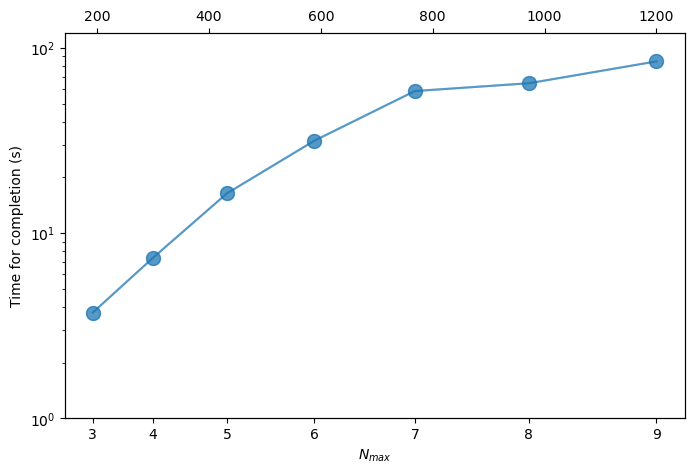

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(n_basis_states, times.values(), '-o', alpha = 0.5,  markersize=10)
ax.set_yscale('log')
ax.set_ylim(1,120)

ax.set_xticks(np.array(n_basis_states))
ax.set_xticklabels([3,4,5,6,7,8,9])

ax.set_ylabel("Time for completion (s)")
ax.set_xlabel("$N_{max}$")

ax2 = ax.twiny() 
ax2.plot(n_basis_states, times.values(), '-o', alpha = 0.5,  markersize=10)

ax2.set_label("Number of basis states")

In [66]:
for N in range(3,10):
    sum = 0
    for n in range(0,N):
        sum += (2*n+1) * ((2*2.5)+1) * ((2*3.5)+1)
    print(N, sum)

3 432.0
4 768.0
5 1200.0
6 1728.0
7 2352.0
8 3072.0
9 3888.0
